# ANOVA Testing

ANOVA (Analysis of Variance) testing can be used for both categorical and regression problems. 

In the context of categorical problems, ANOVA is typically used to compare the means of two or more groups to determine whether there is a statistically significant difference between them. 

In the context of regression problems, ANOVA is typically used to analyze the variance in the dependent variable (the variable being predicted) that can be attributed to the independent variables (the variables used to make the predictions).  ANOVA regression is used to determine whether there is a significant relationship between the independent variables and the dependent variable, and to identify which independent variables are most strongly related to the dependent variable.

### Assumptions of ANOVA testing
- **Independence:** The observations within each group are independent of each other and there are no hidden relationships among observations.
- **Normality:** The data within each group follow a normal distribution.
- **Homogeneity of variance:** The variation within each group being compared is similar for every group. If the variances are different among the groups, then ANOVA probably isn’t the right fit for the data. As a rule of thumb, if the ratio of the largest to the smallest sample standard deviation is less than 2, we consider the equal standard deviations assumption as fulfilled.


### Sources
- [one-way-anova](https://www.scribbr.com/statistics/one-way-anova/)
- [two-way-anova](https://www.scribbr.com/statistics/two-way-anova/)
- [python-anova](https://www.reneshbedre.com/blog/anova.html)
- [python-anova-2](https://www.youtube.com/watch?v=EWYzeZbchR0)
- [University Berlin](https://www.geo.fu-berlin.de/en/v/soga/Basics-of-statistics/ANOVA/One-way-ANOVA/index.html)
- [Equality of variance](https://www.pythonfordatascience.org/parametric-assumptions-python/)

In [1]:
from pathlib import Path
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pylab as plt

### ANOVA on quantitative data(regression problem)

In [2]:
DATA_PATH = Path('/home/io/Desktop/math_ML/handsOn_ML')

In [3]:
# load house prices dataset
df = pd.read_csv(DATA_PATH.joinpath('raw','housing.csv'))

In [5]:
# check for nan values
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
# keep only numerical values
df = df.drop(columns=['longitude','latitude','ocean_proximity'])

In [11]:
df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


### Check if the assumptions for ANOVA testing are met

#### Test for normality

We see on the plots below, the features are not normally distributed. Hence, the results from ANOVA testing might not be reliable. In order to fix this, we need to convert the skewed data into normally distributed

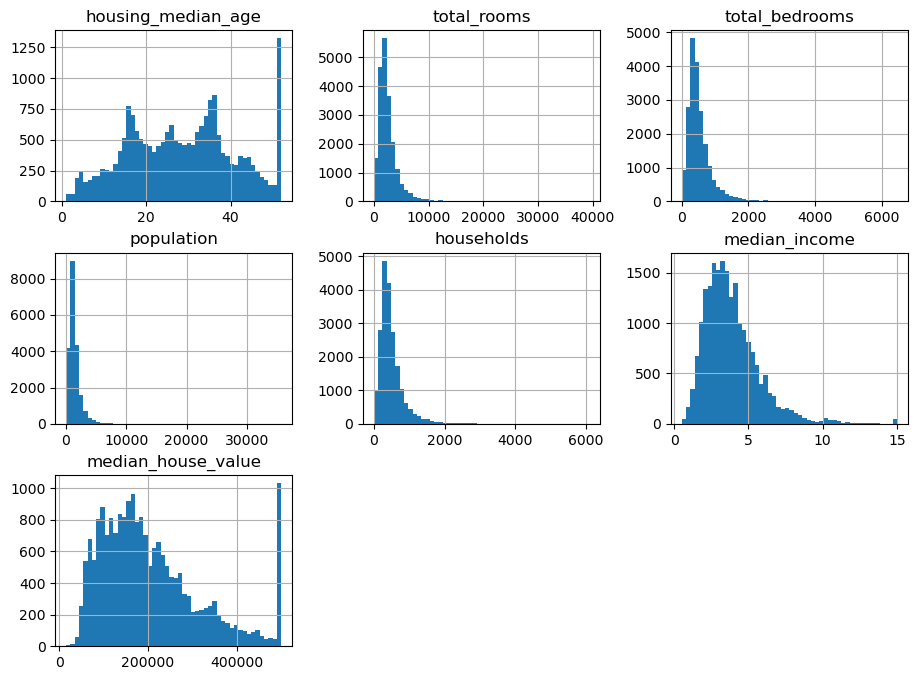

In [7]:
df.hist(bins=50, figsize=(11,8));

In [20]:
def normal_distribution(mean, sigma):
    '''Create data sample that follows a normal distribution
    '''
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
    sample = np.random.normal(mean, sigma, 10000)
    return sample

def plot(df, col, label):
    '''Plot skewed data along with its Q-Q plot
    '''
    plt.figure(figsize=(12,3))
    # create normally distributed data
    s = normal_distribution(mean=0, sigma=1)
    name = f"{col} standardised"
    df[name] = (df[col] - df[col].mean())/(df[col].std())
    
    ax1 = plt.subplot(1,2,1)
    sns.histplot(s,bins=25, stat="density", binwidth=0.1, color='r',label='Normal Distribution',ax=ax1)
    sns.histplot(data=df, x=name, binwidth=0.1, stat="density",color='b',label=f"{col}",alpha=0.4, ax=ax1)
    
    ax2 = plt.subplot(1,2,2)
    res = stats.probplot(df[name], plot=plt)
    ax1.set_title('Histogram')
    ax1.legend()
    plt.show()

In [7]:
df_copy = df.copy()

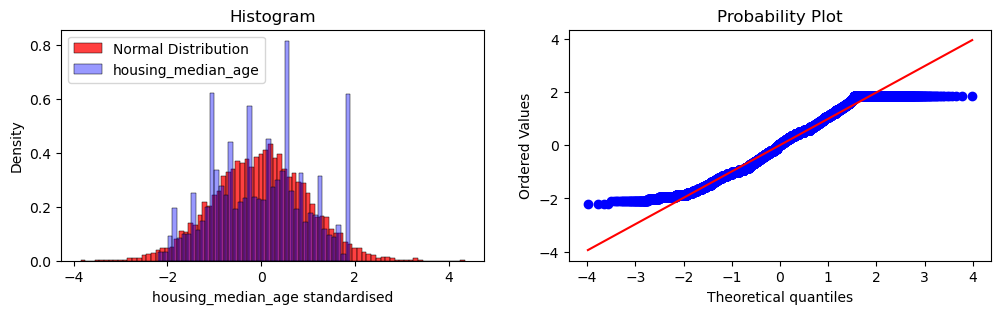

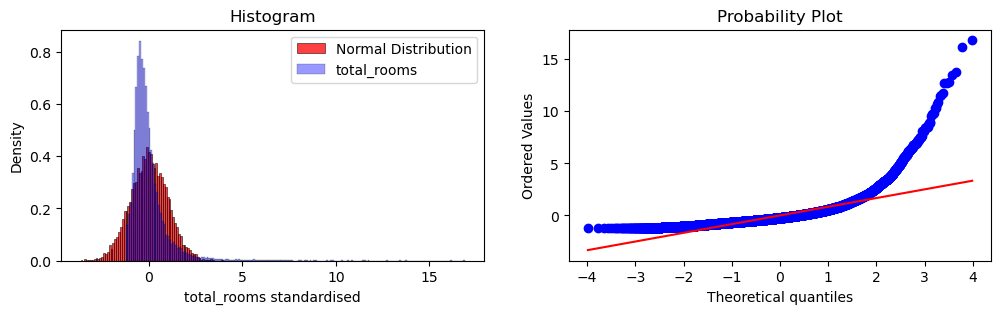

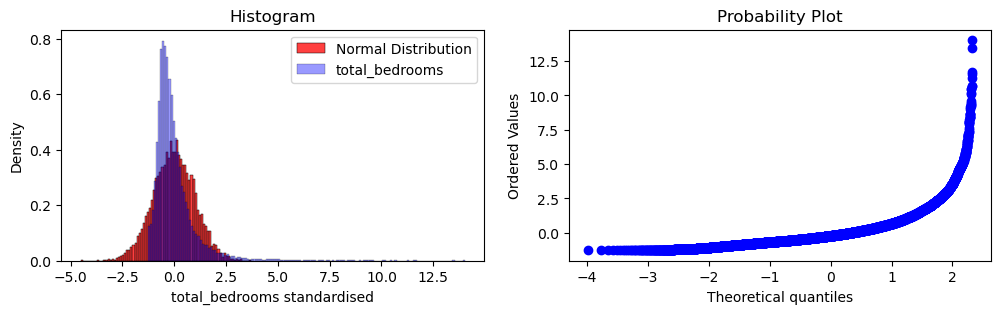

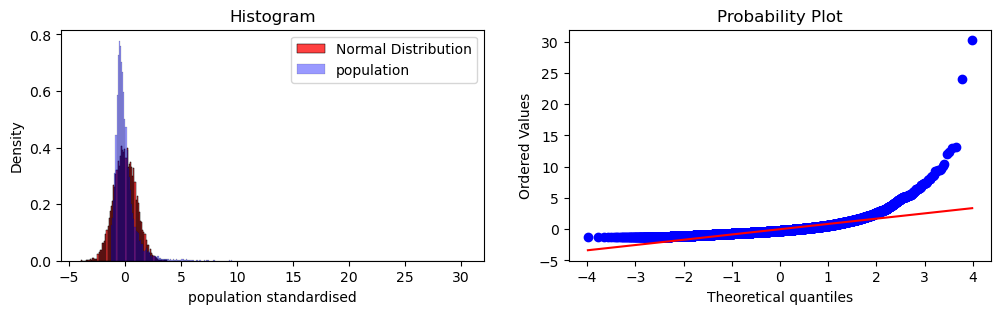

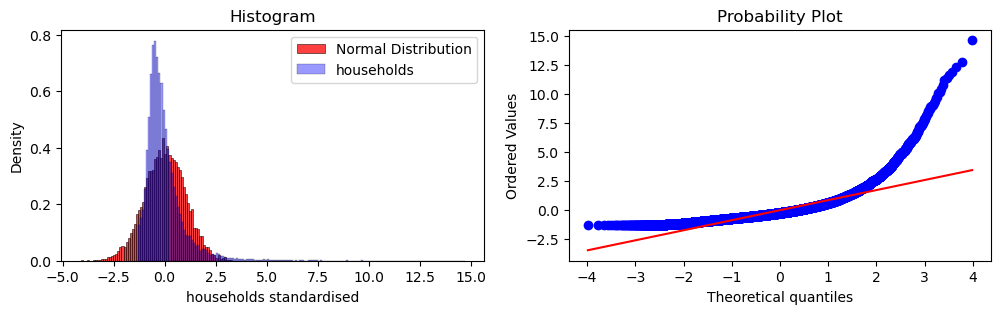

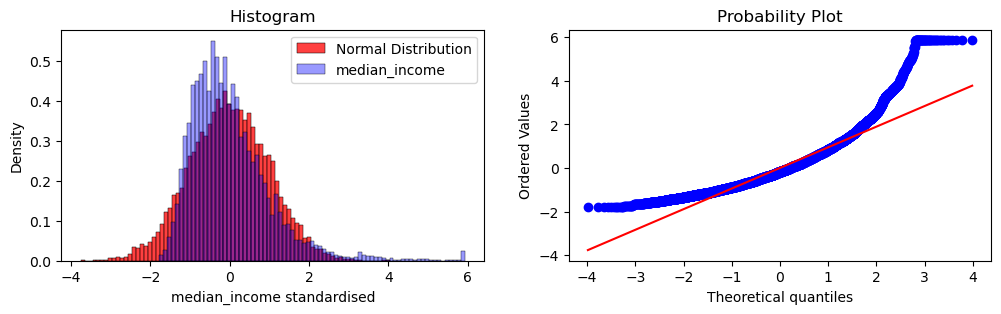

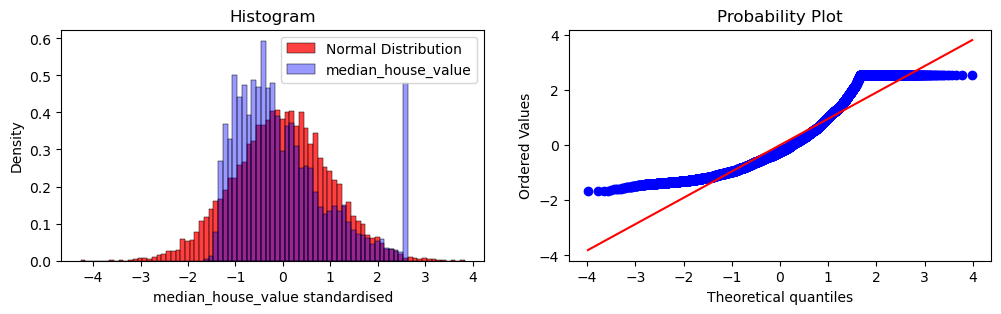

In [24]:
features = df_copy.columns
for p in features:
    plot(df_copy, col=p, label=p)

We can observe from the Q-Q plots above that the blue points diverge from the red line which indicates that those features are not normally distributed

In [12]:
for k,v in df.items():
    # housing median age data is close to a normal distribution
    if k == 'housing_median_age':
        continue
    col_name = f"{k}_log"
    df[col_name] = np.log(df[k])

In [13]:
df_normal = df[df.columns[7:]]

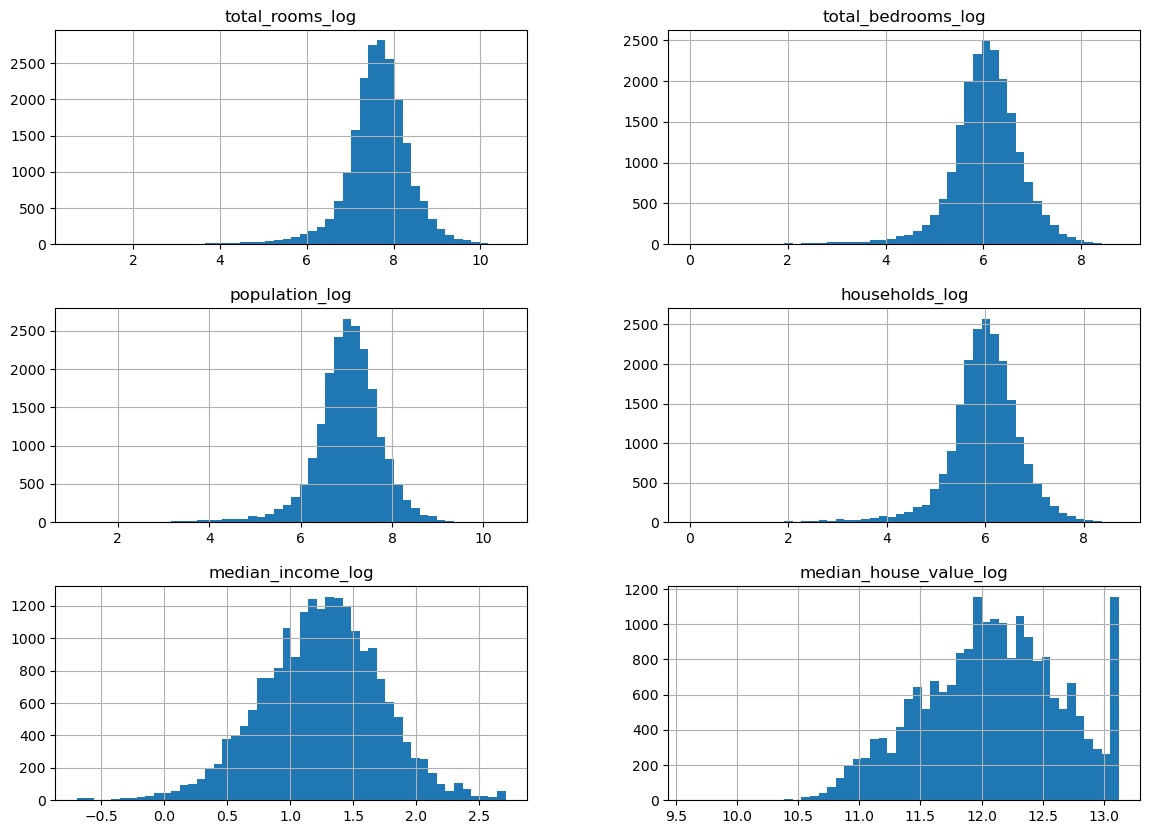

In [24]:
df_normal.hist(bins=50, figsize=(14,10));

After the transformation of features into logarithmic scale, the distribution of the data look more normal

#### Test for variance homegeneity

Below we will estimate the variance for each group to see if there are any significant differences between each feature.
Another way we can test for homogeneity is using [levente](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html) testing

In [14]:
for k,v in df_normal.items():
    var = np.round(df[k].var(),3)
    print (f"Variance of {k}: {var}")

Variance of total_rooms_log: 0.565
Variance of total_bedrooms_log: 0.537
Variance of population_log: 0.546
Variance of households_log: 0.538
Variance of median_income_log: 0.221
Variance of median_house_value_log: 0.324


There are no much difference in variance amonst features. The last two features show smaller variance than the rest

#### ANOVA Testing

In [38]:
model = ols('median_house_value_log ~ total_rooms_log +total_bedrooms_log +population_log+households_log+median_income_log',
            data=df_normal).fit()
anova = anova_lm(model, typ=2)
print (anova)

                         sum_sq       df             F         PR(>F)
total_rooms_log      359.434674      1.0   2481.495358   0.000000e+00
total_bedrooms_log   116.517561      1.0    804.423746  1.350162e-173
population_log       196.459022      1.0   1356.330331  1.554728e-287
households_log       104.863303      1.0    723.964099  9.861393e-157
median_income_log   2505.303454      1.0  17296.324883   0.000000e+00
Residual            2958.769219  20427.0           NaN            NaN


Looking at the `p-value` of the table (PR(>F)) for each feature, we see that it is very small for every feature (usually  a p-value of 0.05. Values below 0.05 indicate a difference between two groups and we can reject teh Null hypothesis). This indicates that there is a significat deifference between the `dependent` variable and the `independent` variables. Hence, there is no correlation between `dependent` and `independent` variables which means all features contribute new information and we can use them to make predictions